<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-small.png"/></a>
<a href="https://shebanq.ancient-data.org" target="_blank"><img align="left"src="images/shebanq_logo_small.png"/></a>
<a href="http://dx.doi.org/10.17026/dans-z6y-skyh" target="_blank"><img align="left"src="images/DANS-logo_small.png"/></a>
<a href="https://www.dbg.de/index.php?L=1" target="_blank"><img align="right" src="images/DBG-small.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="right" src="images/VU-ETCBC-small.png"/></a>

# Topic analysis

Joint work of Mathias Coeckelbergs and Dirk Roorda.

Mathias is experimenting with topic detection experiments using Mallet.
Here is a way to visualize topics.

We are still in a preliminary stage (2016-04-06).

# Start up

In [9]:
import os, sys, collections, re
import networkx as nx
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Data source

In [2]:
source='etcbc'
version='4b'

# Topic sources

In [3]:
topic_files = glob('{}_*_keys.txt'.format(source))
topic_files

['etcbc_30_keys.txt',
 'etcbc_40_keys.txt',
 'etcbc_50_keys.txt',
 'etcbc_60_keys.txt',
 'etcbc_70_keys.txt',
 'etcbc_80_keys.txt',
 'etcbc_90_keys.txt']

# Read the topic files

Every topic is a number. We will give a new name to each topic, namely

    nn-tp
    
where `nn` is the number of topics in the file (indicated in the file name) and
`tp` is the topic number within the file.

We collect the topics in a dictionary containing for each topic the set of its words.

In [10]:
mask = re.compile('{}_([0-9]+)_keys.txt'.format(source))
topic = {}

def get_topics(n, tfile):
    with open(tfile) as fh:
        for line in fh:
            (tp, nm, word_list) = line.rstrip().split('\t')
            words = word_list.split()
            topic['{}-{}'.format(n, tp)] = words
        
    
for topic_file in topic_files:
    ntopic = mask.match(topic_file).group(1)
    get_topics(ntopic, topic_file)

print('{} topics found'.format(len(topic)))

420 topics found


# Word index

We make an inverse mapping as well: a dictionary that for each word gives the set of topics that contain that word.

In [11]:
word_topic = collections.defaultdict(set)

def word2topic():
    for tp in topic:
        for w in topic[tp]: word_topic[w].add(tp)
    print('{} words found'.format(len(word_topic)))

word2topic()

4725 words found


# Edges

Now we can compute edges. We make an edge between each pair of topics that share a word.
Topics may be connected by multiple edges. The edges are undirected.

The method is: walk through all the words, pick the ones that belong to multiple topics, and create an edge for
every pair among those multiple topics.

In [12]:
edges = []

def get_edges():
    for w in word_topic:
        tps = sorted(word_topic[w])
        ntps = len(tps)
        if ntps > 1:
            for i in range(ntps - 1):
                for j in range(i+1, ntps):
                    edges.append((tps[i], tps[j]))
    print('{} edges found'.format(len(edges)))

get_edges()

5783 edges found


# Writing

We write the graph in ncol format, so that it can be loaded into other tools.
This is not needed for the rest of this notebook.

In [13]:
NCOL_FILE = 'edges.ncol'
def write_ncol():
    with open(NCOL_FILE, 'w') as fh:
        for e in edges: fh.write('{}\t{}\n'.format(*e))

write_ncol()

# The graph

We create a graph directly from the list of edges.

In [15]:
g = nx.Graph()
g.add_edges_from(edges)

# Draw

We draw the graph.
Here is just the standard way, without any customization.

See the [networkx docs](https://networkx.github.io) for more sophisticated drawing.

The drawing is also saved as a pdf file.

[(1.0, 0.0, 1.0), (0.0, 0.0, 1.0), (1.0, 0.0, 1.0), (1.0, 0.0, 1.0), (1.0, 1.0, 0.0)]


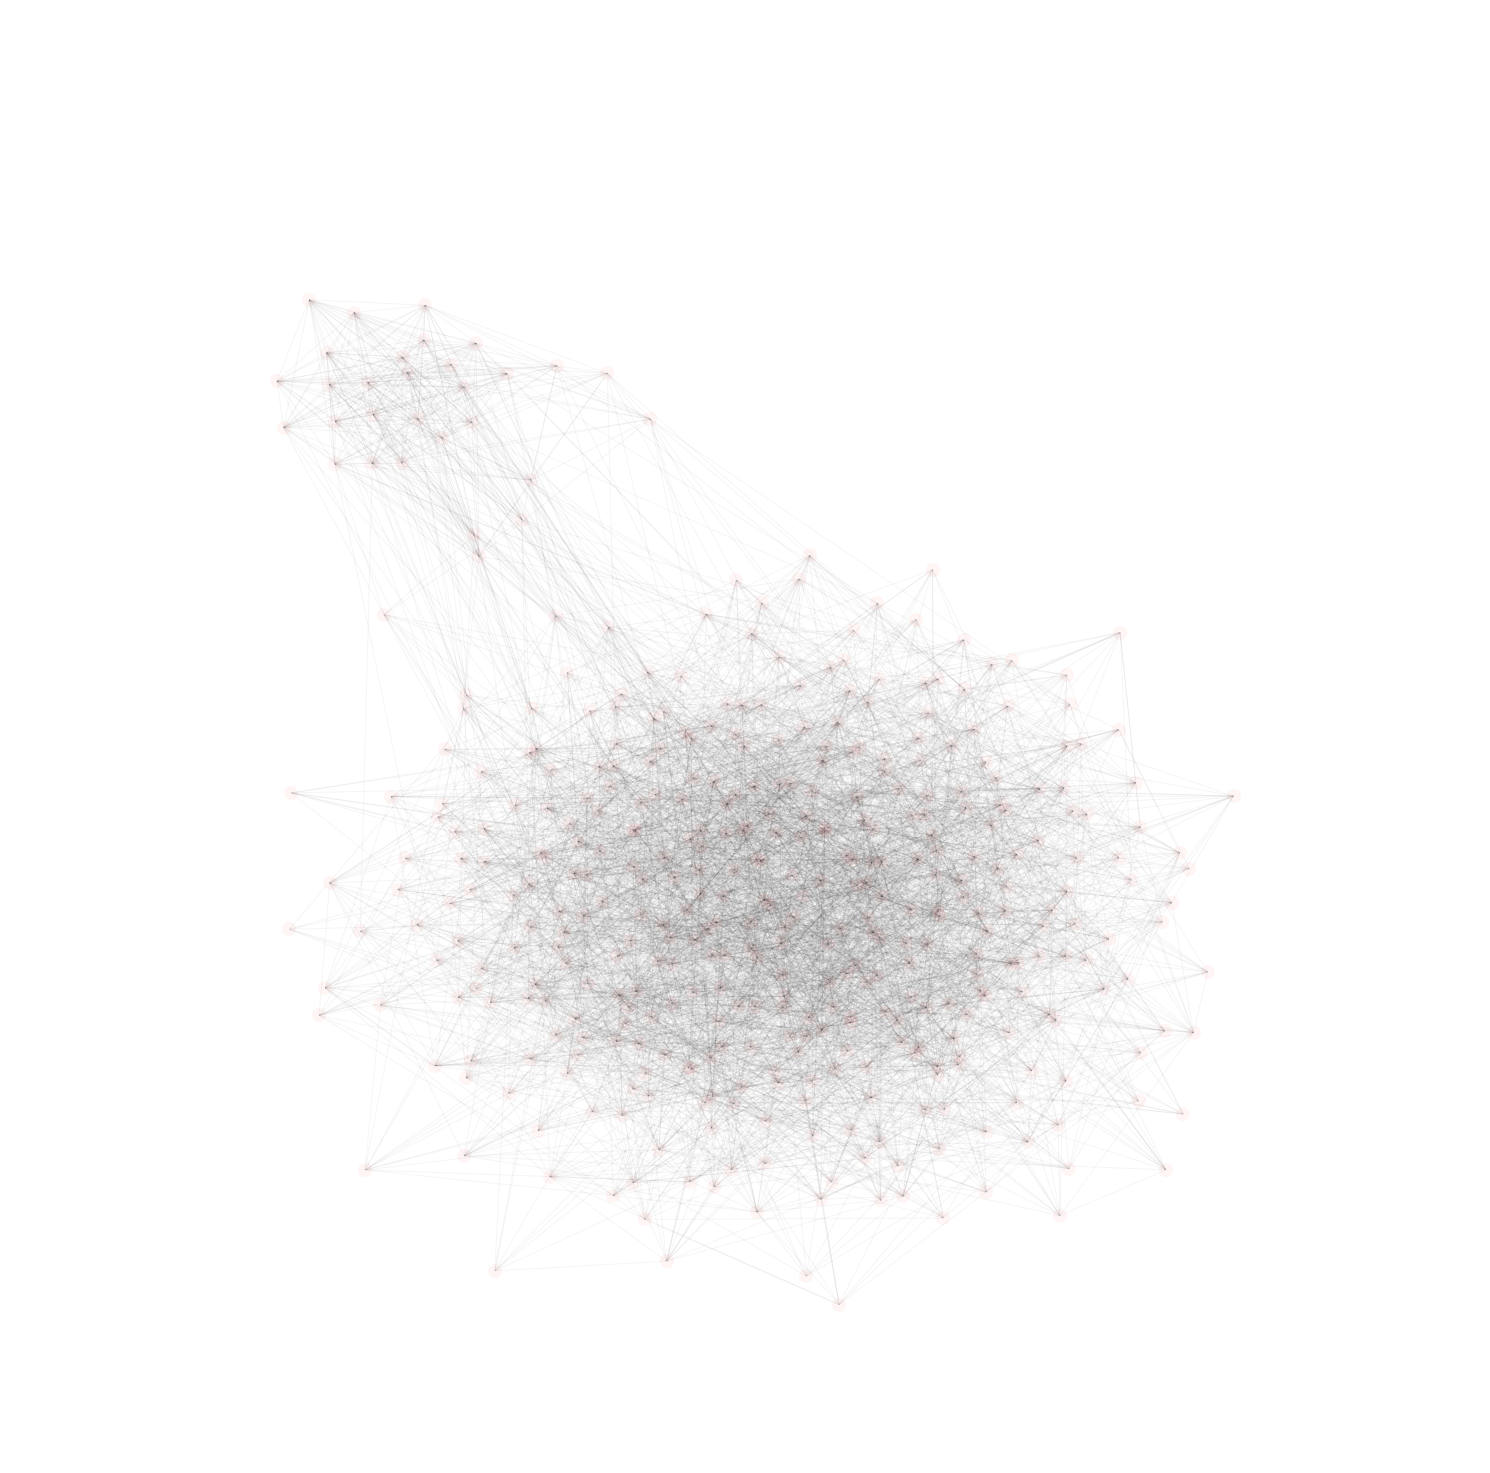

In [33]:
gcolors = {
    30: (0.0, 0.0, 1.0),
    40: (0.0, 1.0, 0.0),
    50: (0.0, 0.0, 1.0),
    60: (0.0, 1.0, 1.0),
    70: (1.0, 0.0, 1.0),
    80: (1.0, 1.0, 0.0),
    90: (0.7, 0.3, 0.0),
}
ncolors = [gcolors[int(x.split('-')[0])] for x in g.nodes()]
print(ncolors[0:5])

plt.figure(figsize=(20,20))
nx.draw(g,
    node_colors = ncolors,
    node_size=200,
    alpha=0.04,
    linewidths=0,
)
#plt.savefig("topics.pdf")